In [22]:
from train_gpu import bgs 
import h5py 
import torch
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

In [23]:
def generate_binary_code(bit_length, batch_size_exp=None, batch_number=0):
    # No batch size is given, all data is returned
    if batch_size_exp is None:
        batch_size_exp = bit_length
    batch_size = 2 ** batch_size_exp
    # Generate batch
    bit_combinations = np.zeros((batch_size, bit_length))
    for number in range(batch_size):
        dividend = number + batch_number * batch_size
        bit_index = 0
        while dividend != 0:
            bit_combinations[number, bit_index] = np.remainder(dividend, 2)
            dividend = np.floor_divide(dividend, 2)
            bit_index += 1
    return bit_combinations

def generate_bars_and_stripes_complete(length):
    """ Creates a dataset containing all possible samples showing bars or stripes.

    :param length: Length of the bars/stripes.
    :type length: int

    :return: Samples.
    :rtype: numpy array [num_samples, length*length]
    """
    stripes = generate_binary_code(length)
    stripes = np.repeat(stripes, length, 0)
    stripes = stripes.reshape(2 ** length, length * length)

    bars = generate_binary_code(length)
    bars = bars.reshape(2 ** length * length, 1)
    bars = np.repeat(bars, length, 1)
    bars = bars.reshape(2 ** length, length * length)
    return np.vstack((stripes[0:stripes.shape[0]-1],bars[1:bars.shape[0]]))
    # return numx.vstack((stripes, bars)) # Tests have to match if changed to this.

def plot_image(
    sample, shape=(28, 28), grid_size=(10, 10), show_grid=False, randomize=True
):
    """Args:
    sample
    shape: (Default value = (28)
    28)
    grid_size: (Default value = (10)
    10)
    show_grid: (Default value = False)
    randomize: (Default value = True)
    """
    num_samples = grid_size[0] * grid_size[1]
    if randomize:
        id_sample = np.random.randint(0, sample.shape[0], num_samples)
    else:
        id_sample = np.arange(num_samples)

    # Create a display array with the appropriate size
    display = np.zeros((shape[0] * grid_size[0], shape[1] * grid_size[1]))

    for i, id_s in enumerate(id_sample):
        # Calculate the row and column for the grid
        idx = i // grid_size[1]  # Row index
        idy = i % grid_size[1]  # Column index

        # Ensure the sample can be reshaped to the specified shape
        display[
            (idx * shape[0]) : ((idx + 1) * shape[0]),
            (idy * shape[1]) : ((idy + 1) * shape[1]),
        ] = sample[id_s].reshape(
            shape
        )  # Directly reshape to shape

    # Plot the display image
    fig, ax = plt.subplots(1, 1)
    ax.imshow(display, cmap="gray")
    ax.axis("off")  # Hide axes

    if show_grid:
        # Minor ticks for the grid
        ax.set_xticks(np.arange(-0.5, grid_size[1] * shape[1], shape[1]), minor=True)
        ax.set_yticks(np.arange(-0.5, grid_size[0] * shape[0], shape[0]), minor=True)

        # Gridlines based on minor ticks
        ax.grid(which="minor", color="gray", linestyle="-", linewidth=2)

In [24]:
with h5py.File("rbm_parameters.h5", "r") as f:
    print(f.keys()) 

    w     = np.array(f['weight_matrix'])
    eta   = np.array(f['eta_vector'])    
    theta = np.array(f['theta_vector'])
    llh   = np.array(f['log_likelihoods'])

    print(w)
    print(eta)
    print(theta)
    print(llh)

w     = torch.tensor(w, dtype=torch.float32)     if isinstance(w, np.ndarray) else w
eta   = torch.tensor(eta, dtype=torch.float32)   if isinstance(eta, np.ndarray) else eta
theta = torch.tensor(theta, dtype=torch.float32) if isinstance(theta, np.ndarray) else theta


inputs_np = generate_bars_and_stripes_complete(4)
nb_samples = inputs_np.shape[0]
Nv, Nh = w.shape

<KeysViewHDF5 ['eta_vector', 'log_likelihoods', 'theta_vector', 'weight_matrix']>
[[-0.00776061 -0.00776061 -0.00776061 -0.00776061 -0.00776061 -0.00776061
  -0.00776061]
 [ 0.00215014  0.00215014  0.00215014  0.00215014  0.00215014  0.00215014
   0.00215014]
 [-0.0009647  -0.0009647  -0.0009647  -0.0009647  -0.0009647  -0.0009647
  -0.0009647 ]
 [-0.0144634  -0.0144634  -0.0144634  -0.0144634  -0.0144634  -0.0144634
  -0.0144634 ]
 [-0.01241747 -0.01241747 -0.01241747 -0.01241747 -0.01241747 -0.01241747
  -0.01241747]
 [ 0.00257368  0.00257368  0.00257368  0.00257368  0.00257368  0.00257368
   0.00257368]
 [-0.01181698 -0.01181698 -0.01181698 -0.01181698 -0.01181698 -0.01181698
  -0.01181698]
 [-0.01980957 -0.01980957 -0.01980957 -0.01980957 -0.01980957 -0.01980957
  -0.01980957]
 [-0.00031    -0.00031    -0.00031    -0.00031    -0.00031    -0.00031
  -0.00031   ]
 [ 0.00541291  0.00541291  0.00541291  0.00541291  0.00541291  0.00541291
   0.00541291]
 [-0.00396733 -0.00396733 -0.0039

In [25]:
start_v = torch.randint(0, 2, (nb_samples, Nv)).float()
sample_v = bgs(start_v, w, eta, theta, 10)[1]

### Visualisation d'une image generee

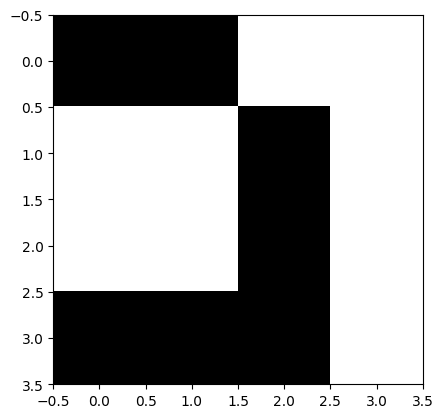

In [26]:
plt.imshow(sample_v[0].reshape(4, 4), cmap='gray')

In [27]:
print(inputs_np)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0.]
 [1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1.]
 [0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1.]
 [1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1.]
 [0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 1. 1.

## Affichage (10x10) des inputs 

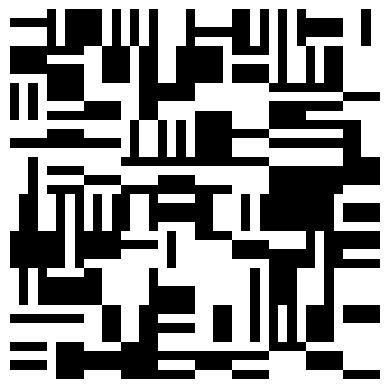

In [28]:
plot_image(sample=inputs_np.astype(int), shape=(4, 4), grid_size=(10, 10), show_grid=True)

## Affichage (10x10) des nouveaux echantillons 

/tmp/ipykernel_1102/516819317.py:64: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  display[


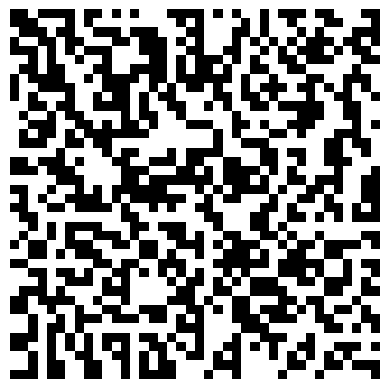

In [29]:
plot_image(sample=sample_v, shape=(4, 4), grid_size=(10, 10), show_grid=True)

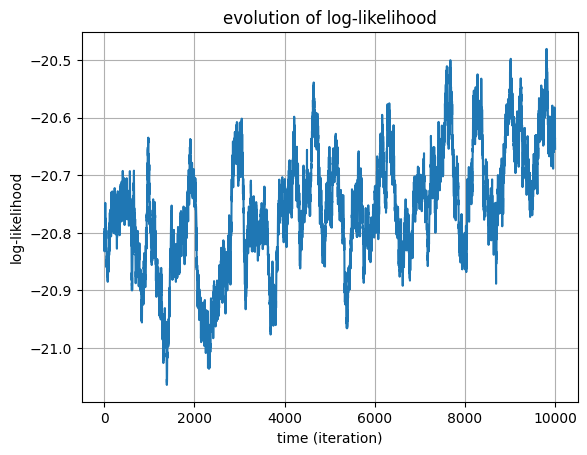

In [32]:
plt.plot(llh)
plt.xlabel("time (iteration)")
plt.ylabel("log-likelihood")
plt.title("evolution of log-likelihood")
#plt.loglog()
plt.grid(True)